# Table of Contents
 <p><div class="lev1"><a href="#Derive-scaling"><span class="toc-item-num">1&nbsp;&nbsp;</span>Derive scaling</a></div><div class="lev2"><a href="#Compute-statistics"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Compute statistics</a></div><div class="lev3"><a href="#1D-PDFs"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>1D PDFs</a></div><div class="lev3"><a href="#Decompose-variance-into-its-contributions-from-qvstar-and-omega"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Decompose variance into its contributions from qvstar and omega</a></div><div class="lev3"><a href="#Simpler-decomposition-for-OGS09-scaling"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Simpler decomposition for OGS09 scaling</a></div><div class="lev3"><a href="#Redo-simpler-decomposition-for-single-level-scaling"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>Redo simpler decomposition for single-level scaling</a></div><div class="lev1"><a href="#Save-variables"><span class="toc-item-num">2&nbsp;&nbsp;</span>Save variables</a></div>

In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
%autoreload 2

print("-- loading modules")
print()

import numpy as np
import numpy.ma as ma
import dask.array as da
import matplotlib
# matplotlib.use("PDF")
import matplotlib.pyplot as plt
import datetime as dt
import time
import sys,os,glob
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LogNorm
import pickle

## Add own library to path
workdir = os.getcwd()
thismodule = sys.modules[__name__]
moduledir = os.path.join(os.path.dirname(workdir),'functions')
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])

## Load own libraries
from environmentAndDirectories import *
from importingData import *
from scalingApproximations import *
from slicingAndSubsetting import *
from thermoConstants import L_v,R_v
from plotMaps import *
from plot1DInvLog import *
from plot2D import *
from statisticalDistributions import *
from outputResults import *

## Graphical parameters
plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

-- loading modules

Own modules available: ['plot1DInvLog', 'thermoFunctions', 'statisticalDistributions', 'slicingAndSubsetting', 'plot2D', 'outputResults', 'thermoConstants', 'plotMaps', 'daskOptions', 'scalingApproximations', 'CAMsettings', 'environmentAndDirectories', 'importingData', 'physicalConstants']


In [3]:
%%time
print("-- load environment and variables")
print()

omega_id = 'OMEGA'
pr_id = 'PRECT'
ts_id = 'TS'
ta_id = 'T'
relhum_id = 'RELHUM'
ps_id = 'PS'

all_varnames = 'omega','pr','ts','ta','relhum','ps','pres'

ref_time_stride = '1h'
ref_resolution = '1dx'

print("- load data for the following options:")
compset = 'FSPCAMm_AMIP'
experiment = 'piControl'
member = 'r1i1p1'
subset = 'tropics'
daskarray = False
tracktime = True
# dates = ('185005010100','185005020000')
dates = ('185005010100','185105010000')
handle = 'h0'
plotAll2dPDFs = True
bootstrap = True

-- load environment and variables

- load data for the following options:
CPU times: user 497 µs, sys: 162 µs, total: 659 µs
Wall time: 407 µs


In [4]:
if tracktime:
    t0 = time.time()
    t_loops = []

In [5]:
for v in ['compset','experiment','member','subset','ref_time_stride','ref_resolution',\
          'daskarray','dates']:
    print("%s:"%v,getattr(thismodule,v))

print()
omega_init,pr_init,ts_init,ta_init,relhum_init,ps_init = \
    getValues([omega_id,pr_id,ts_id,ta_id,relhum_id,ps_id],
              compset,subset,experiment,ref_time_stride,ref_resolution,
              daskarray=daskarray,dates=dates,handle=handle)
pr_init *= rho_l    # convert from m/s to kg/m2/s

print()
print("get inputpaths")

historyFilesSettings = getCAMHistoryFilesSettings()
inputdir, inputdir_processed_day, inputdir_processed_1hr, inputdir_results, inputdir_fx = \
    getInputDirectories(compset,experiment)

print("compute pressure levels")
    
input_lev_file = os.path.join(inputdir_fx,'lev_fx_CESM111-SPCAM20_allExperiments_r0i0p0.nc')
computeP = getPressureCoordinateFunction(input_lev_file)
pres_init = computeP(ps_init)

cn = getArrayType(pres_init)

compset: FSPCAMm_AMIP
experiment: piControl
member: r1i1p1
subset: tropics
ref_time_stride: 1d
ref_resolution: 1dx
daskarray: False
dates: ('185005010100', '185105010000')

Importing OMEGA, PRECT, TS, T, RELHUM, PS from 1577 history files between 1850-05-01-03600 and 1850-07-05-61200

get inputpaths
compute pressure levels


In [6]:
if tracktime:
    t1 = time.time()
    t_loops.append(t1)
    print()
    print("! time spent to load the data:",time2str(t1-t0))



! time spent to load the data: 00:04:55


In [7]:
#---- single scale ----#
# start comment
time_stride = '1d'
resolution = '1dx'
# stop comment

#---- multiple scales ----#
# # start uncomment
# time_strides = '1h','3h','6h','12h','1d','2d','4d','8d'
# resolutions = '1dx','2dx','3dx','4dx','5dx','6dx','7dx','8dx','9dx'
# for time_stride in time_strides:
#     for resolution in resolutions:
# # stop uncomment

#++# start indentation for multiple scales

print()
print("-----------------------------------------------------------------")
print("!          Start analysis for time_stride {:4}                  !".format(time_stride))
print("!                          and resolution {:4}                  !".format(resolution))
print("-----------------------------------------------------------------")
print()


-----------------------------------------------------------------
!          Start analysis for time_stride 1d                    !
!                          and resolution 1dx                   !
-----------------------------------------------------------------



In [8]:
print("convert data to target resolutions")

tc0 = time.time()

for varname in all_varnames:
    
    tc1 = time.time()
    setattr(thismodule,varname,
            coarsenTimeStride(coarsenResolution(getattr(thismodule,"%s_init"%varname),
                                                resolution),
                              time_stride,time_stride_ref=ref_time_stride))
    print("- %s:"%varname,time.time()-tc1,'s')
print("- all variables:",time.time()-tc0,'s')

qvstar = saturationSpecificHumidity(pres=pres,temp=ta)

convert data to target resolutions
- omega: 0.05018210411071777 s
- pr: 0.0013992786407470703 s
- ts: 0.0010139942169189453 s
- ta: 0.043198585510253906 s
- relhum: 0.043673038482666016 s
- ps: 0.001132965087890625 s
- pres: 0.11805200576782227 s
- all variables: 0.26210880279541016 s


In [9]:
print()
print("-- define output paths")
print()

# Figure output directory
figdir = os.path.join(os.path.dirname(workdir),'figures','omega500tsps',compset,experiment,member,subset,\
                      time_stride,resolution)
os.makedirs(figdir,exist_ok=True)

# Results output directory
resultdir = os.path.join(os.path.dirname(workdir),'results','omega500tsps',compset,experiment,member,subset,\
                      time_stride,resolution)
os.makedirs(resultdir,exist_ok=True)

print()


-- define output paths




# Derive scaling

In [10]:
print()
print("-- compute (percentile-wise and pointwise) scaling approximation")
print()


-- compute (percentile-wise and pointwise) scaling approximation



In [11]:
# %%time
print("compute 2D surfaces of predictor variables")
p_500 = 50000
p_925 = 92500; levdim=1
omega_500 = isobaricSurface(omega,pres,p_ref=p_500,levdim=levdim)
use925 = True
if use925:
    ta_925 = isobaricSurface(ta,pres,p_ref=p_925,levdim=levdim) 
    qvstar_s = saturationSpecificHumidity(ta_925,p_925*np.ones(ps.shape))
else:
    qvstar_s = saturationSpecificHumidity(ts,ps)

compute 2D surfaces of predictor variables


In [12]:
%%time
print("Compute ranks and ranks locations")

n_pts = pr.size
Q_IL = getInvLogRanks(n_pts,n_pts_per_bin=1,fill_last_decade=True)
i_Q = indexOfRank(99.9,Q_IL)
iQ_slice = slice(i_Q-5,i_Q+5)
ranks, centers, bins = computePercentilesAndBinsFromRanks(pr.flatten(),Q_IL)
iQ_min = 8
iQ_max = min(len(Q_IL),41)
# iQ_max = min(len(Q_IL),iQ_slice.stop)

# Define reference percentiles and compute percentiles
targetranks = Q_IL[iQ_min:iQ_max]
ranks_ref = Q_IL[:iQ_max]
percentiles = adjustRanks(centers,ranks,ranks_ref)

# Suffix to save figures and results
output_suffix = 'Q%d-Q%d_%s'%(iQ_min,iQ_max,'-'.join(dates))

rank_locations= {}
for rank in ranks_ref:
    rank_id  = "%2.4f"%rank
    print(rank_id,end=' ')
    rank_locations[rank_id] = getRankLocations(rank,pr,ranks,bins,rank_locations)
print()

Compute ranks and ranks locations
0.0000 20.5672 36.9043 49.8813 60.1893 68.3772 74.8811 80.0474 84.1511 87.4107 90.0000 92.0567 93.6904 94.9881 96.0189 96.8377 97.4881 98.0047 98.4151 98.7411 99.0000 99.2057 99.3690 99.4988 99.6019 99.6838 99.7488 99.8005 99.8415 99.8741 99.9000 99.9206 99.9369 99.9499 99.9602 99.9684 99.9749 99.9800 99.9842 99.9874 99.9900 
CPU times: user 26.9 ms, sys: 6.24 ms, total: 33.1 ms
Wall time: 30.1 ms


In [13]:
print("compute sample size in each bin")
N_prQ = sampleSizeAtAllRanks(targetranks,pr,ranks_ref,rank_locations=rank_locations)
print(np.nansum(N_prQ),pr.size)

compute sample size in each bin
66269.0 299520


In [14]:
%%time
print("compute pointwise scaling")
eps, pr_sc_vQ = computeScalingOmegaQAtAllRanks(targetranks,omega_500,qvstar_s,pr,ranks_ref=ranks_ref[iQ_slice],
                                               percentiles_ref=percentiles[iQ_slice],
                                               bins=bins,rank_locations=rank_locations)
pr_sc_vQ = adjustRanks(pr_sc_vQ,targetranks,ranks_ref)
pr_sc = singleLevelScalingFromOmegaQ(omega_500,qvstar_s,efficiency=eps)
print("eps =",eps)

compute pointwise scaling
eps = 0.819981052179
CPU times: user 59.3 ms, sys: 2.35 ms, total: 61.7 ms
Wall time: 61 ms


In [15]:
%%time
print("compute O'Gorman&Schneider scaling with environmental temperature profile")
eps_OGS09, pr_scOGS09_vQ = computeScalingOGS09AtAllRanks(targetranks,omega,ta,pres,pr,
    ranks_ref=ranks_ref[iQ_slice],percentiles_ref=percentiles[iQ_slice],bins=bins,
                                                         rank_locations=rank_locations)
pr_scOGS09_vQ = adjustRanks(pr_scOGS09_vQ,targetranks,ranks_ref)
pr_scOGS09 = scalingOGS09(omega,ta,pres,efficiency=eps_OGS09,levdim=1)
print("eps_OGS09 =",eps_OGS09)

compute O'Gorman&Schneider scaling with environmental temperature profile
eps_OGS09 = 1.00158272811
CPU times: user 16.5 s, sys: 5.92 s, total: 22.4 s
Wall time: 22.4 s


In [16]:
%%time
print("compute O'Gorman&Schneider scaling with moist adiabat")
# Get temperature values at lowest level
levdim = 1
nlev = pres.shape[levdim]
i_bottom = bottomIndex(np.moveaxis(pres,levdim,-1).ravel()[-nlev:])
ta_bottom = np.take(ta,axis=levdim,indices=i_bottom)
# Compute scaling
eps_OGS09ad, pr_scOGS09ad_vQ = computeScalingOGS09AtAllRanks(targetranks,omega,ta_bottom,pres,pr,
    temp_type='adiabat',relhum=relhum,ranks_ref=ranks_ref[iQ_slice],percentiles_ref=percentiles[iQ_slice],bins=bins,
                                                         rank_locations=rank_locations)
pr_scOGS09ad_vQ = adjustRanks(pr_scOGS09ad_vQ,targetranks,ranks_ref)
pr_scOGS09ad = scalingOGS09(omega,ta_bottom,pres,temp_type='adiabat',relhum=relhum,efficiency=eps_OGS09ad,levdim=1)
print("eps_OGS09ad =",eps_OGS09ad)

compute O'Gorman&Schneider scaling with moist adiabat
eps_OGS09ad = 1.02001742662
CPU times: user 19.3 s, sys: 6.41 s, total: 25.7 s
Wall time: 25.7 s


## Compute statistics

### 1D PDFs

In [17]:
print()
print("-- compute statistics")
print()


-- compute statistics



In [18]:
# %%time
print("mean of scalings in pr bins")
pr_sc_prQ = meanXAtAllYRanks(targetranks,pr_sc,pr,ranks_ref,rank_locations=rank_locations)
pr_scOGS09_prQ = meanXAtAllYRanks(targetranks,pr_scOGS09,pr,ranks_ref,rank_locations=rank_locations)
pr_scOGS09ad_prQ = meanXAtAllYRanks(targetranks,pr_scOGS09ad,pr,ranks_ref,rank_locations=rank_locations)

mean of scalings in pr bins


In [19]:
%%time
print("interquartile and 90% ranges")
ranks_I90 = (5,95)
ranks_IQR = (25,75)

pr_sc_I90 = XPercentilesAtAllYRanks(targetranks,pr_sc,ranks_I90,pr,ranks_ref,rank_locations_X=rank_locations)
pr_sc_IQR = XPercentilesAtAllYRanks(targetranks,pr_sc,ranks_IQR,pr,ranks_ref,rank_locations_X=rank_locations)

pr_scOGS09_I90 = XPercentilesAtAllYRanks(targetranks,pr_scOGS09,ranks_I90,pr,ranks_ref,rank_locations_X=rank_locations)
pr_scOGS09_IQR = XPercentilesAtAllYRanks(targetranks,pr_scOGS09,ranks_IQR,pr,ranks_ref,rank_locations_X=rank_locations)

pr_scOGS09ad_I90 = XPercentilesAtAllYRanks(targetranks,pr_scOGS09ad,ranks_I90,pr,ranks_ref,rank_locations_X=rank_locations)
pr_scOGS09ad_IQR = XPercentilesAtAllYRanks(targetranks,pr_scOGS09ad,ranks_IQR,pr,ranks_ref,rank_locations_X=rank_locations)


interquartile and 90% ranges
CPU times: user 69.5 ms, sys: 812 µs, total: 70.3 ms
Wall time: 69.1 ms


### Decompose variance into its contributions from qvstar and omega

In [20]:
print()
print("-- decompose variance into qvstar and omega contributions")
print()


-- decompose variance into qvstar and omega contributions



In [21]:
%%time 
print("Compute the variance in pr")
scaling_names = 'sc','scOGS09','scOGS09ad'

Ntimes = 100 if bootstrap else 1
fsub = 0.5 if bootstrap else 1

for sc_name in scaling_names:

    # compute variance from full sample
    pr_values = getattr(thismodule,'pr_%s'%sc_name)
    var_pr = varXAtAllYRanks(targetranks,pr_values,
                            pr,ranks_ref,rank_locations=rank_locations)
    setattr(thismodule,'var_pr_%s_prQ'%sc_name,var_pr)
    
    # bootstrapping
    all_var_pr = np.empty((Ntimes,var_pr.size))
    for i in range(Ntimes):
        all_var_pr[i,:] = varXAtAllYRanks(targetranks,pr_values,
                            pr,ranks_ref,rank_locations=rank_locations,random_fraction=fsub)
    if bootstrap:
        setattr(thismodule,'var_pr_%s_I25_prQ'%sc_name,all_var_pr[0])
        setattr(thismodule,'var_pr_%s_I75_prQ'%sc_name,all_var_pr[1])

Compute the variance in pr
CPU times: user 7.8 s, sys: 0 ns, total: 7.8 s
Wall time: 7.8 s


In [22]:
print("normalized variability")
for sc_name in scaling_names:
    norm_var_pr = getattr(thismodule,'var_pr_%s_prQ'%sc_name)/getattr(thismodule,'pr_%s_prQ'%sc_name)**2
    setattr(thismodule,'norm_var_pr_%s_prQ'%sc_name,norm_var_pr)
    if bootstrap:
        for int_bnd in 'I25','I75':
            norm_var_pr_Ibnd = getattr(thismodule,'var_pr_%s_%s_prQ'%(sc_name,int_bnd))/\
                getattr(thismodule,'pr_%s_prQ'%sc_name)**2
            setattr(thismodule,'norm_var_pr_%s_%s_prQ'%(sc_name,int_bnd),norm_var_pr_Ibnd)
            # for printing only:
            setattr(thismodule,'norm_var_pr_%s'%int_bnd,norm_var_pr_Ibnd)
    
    print("scaling %s : %1.5f"%(sc_name,np.nanmean(norm_var_pr[iQ_slice])),end='')
    if bootstrap:
        print("\t (%1.5f,%1.5f)"%(np.nanmean(norm_var_pr_I25[iQ_slice]),
                                  np.nanmean(norm_var_pr_I75[iQ_slice])))
    else:
        print()

normalized variability
scaling sc : 0.01284	 (0.01221,0.01333)
scaling scOGS09 : 0.00571	 (0.00527,0.00553)
scaling scOGS09ad : 0.01081	 (0.01024,0.00993)


In [1]:
# print()
# print("- Compute EOF decomposition and contribution terms -")
# print()

# def contributionsVarianceProduct(X,Y):
    
#     """X and Y are 1d arrays."""
#     var_x = np.nanvar(X)
#     var_y = np.nanvar(Y)
#     cov_term = np.nanmean((X**2-np.nanmean((X**2)))*(Y**2-np.nanmean(Y**2))) - \
#         2*np.nanmean(X)*np.nanmean(Y)*np.nanmean((X-np.nanmean(X))*(Y-np.nanmean(Y)))

#     return var_x,var_y,cov_term

# def getEOFmodes(A,n_max = None,threshold=0.95):
    
#     """levdim is 0"""
    
#     U,S,Vh = np.linalg.svd(A.T)
#     if n_max is None:
#         n_max = np.argmax(np.cumsum((S**2)/(S**2).sum())>threshold)+1
#     phi = np.nan*np.empty((n_max,Vh.shape[1]))
#     lambdas = np.nan*np.empty((n_max,))
#     coefs = np.nan*np.empty((n_max,U.shape[0]))
#     for i in range(min(n_max,len(S))):
#         phi[i] = Vh[i,:]
#         lambdas[i] = S[i]
#         coefs[i] = S[i]*U[:,i]
#     lambda_2_sum = (S**2).sum()
#     return np.array(coefs),np.array(lambdas),np.array(phi),lambda_2_sum

def scOGS09(qvstar_profs,omega_profs,alpha=1,levdim=0):
    
    omega_mid = np.apply_along_axis(arr=omega_profs,axis=levdim,
                                        func1d=(lambda x:np.convolve(x,(0.5,0.5),mode='valid')))
    q_diff = np.diff(qvstar_profs,axis=levdim)
    return alpha*np.sum(omega_mid*q_diff,axis=levdim)/gg

# def computeGramMatrixOfModes(qvstar_modes,omega_modes,pres,levdim=0):
    
#     NX,NY = qvstar_modes.shape[0], omega_modes.shape[0]
    
#     gram = np.empty((NX,NY))
#     for i in range(NX):
#         for j in range(NY):
            
#             gram[i,j] = scOGS09(qvstar_modes[i],omega_modes[j],levdim=levdim)
            
#     return gram

# n_max_qvstar = 2
# n_max_omega = 3
# n_modes = n_max_qvstar*n_max_omega
# contribQOmega_varOGS09_varQ = np.nan*np.empty((n_modes,len(ranks_ref)))
# contribQOmega_varOGS09_varOmega = np.nan*np.empty((n_modes,len(ranks_ref)))
# contribQOmega_varOGS09_covQOmega = np.nan*np.empty((n_modes,len(ranks_ref)))

# for rank in targetranks:
    
#     rankid = rankID(rank)
#     print(rankid, end=', ')

#     #- Get profiles and fluctuations at given percentile
#     stencil_Q = rank_locations[rankid]
#     if stencil_Q.sum() == 0:
#         continue
#     omega_prof_Q = sampleFlattened(omega,stencil_Q)
#     qvstar_prof_Q = sampleFlattened(qvstar,stencil_Q)
#     pres_Q = sampleFlattened(pres,stencil_Q)
#     m_omega_prof_Q = np.mean(omega_prof_Q,axis=1)
#     m_qvstar_prof_Q = np.mean(qvstar_prof_Q,axis=1)
#     m_pres = np.mean(pres_Q,axis=1)
#     prime_omega_prof_Q = np.apply_along_axis(lambda x: x-m_omega_prof_Q,axis=0,arr=omega_prof_Q)
#     prime_qvstar_prof_Q = np.apply_along_axis(lambda x: x-m_qvstar_prof_Q,axis=0,arr=qvstar_prof_Q)

#     #- EOF decomposition
#     c_qvstar, lambda_qvstar, phi_qvstar,lambda_2_sum_qvstar = getEOFmodes(prime_qvstar_prof_Q,n_max=n_max_qvstar)
#     c_omega, lambda_omega, phi_omega, lambda_2_sum_omega = getEOFmodes(prime_omega_prof_Q,n_max=n_max_omega)

#     #- Gram matrix of modes (vertical scaling on each pair of modes)
#     # first dimension are thermodynamic modes, second are dynamic
#     beta_Q = computeGramMatrixOfModes(phi_qvstar,phi_omega,m_pres)
#     omega_mid = np.apply_along_axis(arr=omega_prof_Q,axis=0,
#                                 func1d=(lambda x:np.convolve(x,(0.5,0.5),mode='valid')))
#     qvstar_diff = np.diff(qvstar_prof_Q,axis=0)
#     beta_0 = np.sum(omega_mid*qvstar_diff)/gg

#     #- Compute all contribution terms - store as a new dimension in an array of size dim(beta),#contribs
#     contribs = np.empty(beta_Q.shape+(3,))
#     for i,j in np.ndindex(*(beta_Q.shape)):
#         contribs[i,j,:] = (beta_Q[i,j]/beta_0*lambda_qvstar[i]*lambda_omega[j])**2*\
#             np.array(contributionsVarianceProduct(c_qvstar[i,:],c_omega[j,:]))
#     contribs_prQ = np.vstack(list(contribs))
    
#     #- Store results in array
#     iQ = indexOfRank(rank,ranks_ref)
#     contribQOmega_varOGS09_varQ[:,iQ] = contribs_prQ[:,0]
#     contribQOmega_varOGS09_varOmega[:,iQ] = contribs_prQ[:,1]
#     contribQOmega_varOGS09_covQOmega[:,iQ] = contribs_prQ[:,2]
    
# all_contribQOmega_varOGS09_EOFs = [contribQOmega_varOGS09_varQ,contribQOmega_varOGS09_varOmega,
#                                   contribQOmega_varOGS09_covQOmega]
# print()

> plot variance and corresponding contributions


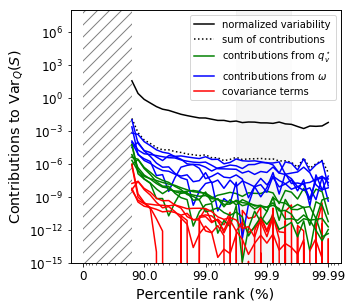

CPU times: user 1.78 s, sys: 68.2 ms, total: 1.85 s
Wall time: 1.85 s


In [30]:
# %%time 
# print("> plot variance and corresponding contributions")

# fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))

# ax.set_ylim((1e-15,1e8))
# ax.set_yscale('log')

# # Grey shading 
# i_Q_lims = (iQ_slice.start, iQ_slice.stop-1)
# subplotXShadingRanksILog(ax,ranks_ref,i_Q_lims,alpha=0.15,transformX=False)

# # zero line
# addZeroLine(ax,ranks_ref)

# # subplotRanksILog(ax,ranks,np.zeros(ranks.shape),ltype=':',col='k')
# subplotRanksILog(ax,ranks_ref,
#                  norm_var_pr_scOGS09_prQ,
#                  col='k',ltype='-',transformX=False)
# # Sum of contributions
# subplotRanksILog(ax,ranks_ref,
#                  np.sum(np.vstack(all_contribQOmega_varOGS09_EOFs),axis=0),
#                  col='k',ltype=':',transformX=False)

# for i in range(n_modes):
#     subplotRanksILog(ax,ranks_ref,
#                      [contribQOmega_varOGS09_varQ[i],contribQOmega_varOGS09_varOmega[i],
#                               contribQOmega_varOGS09_covQOmega[i]],
#                      col=['green','blue','red'],ltype=['-','-','-'],transformX=False)

# addXHatchRanksILog(ax,ranks_ref,(0,iQ_min),transformX=True)

# ax.set_xlabel('Percentile rank (%)')
# ax.set_ylabel(r'Contributions to Var$_Q(S)$')
# # ax.set_title(r'$S(\omega,T)=\varepsilon\omega_{500}q_v^\star(T)$')

# ax.legend(['normalized variability',
#            'sum of contributions',
#            r'contributions from $q_v^\star$',
#            r'contributions from $\omega$',
#            r'covariance terms'],ncol=1,framealpha=0.8,loc='upper right')

# plt.savefig(os.path.join(figdir,'var_and_EOFcontributions_scOGS09_%s.pdf'%output_suffix),
#             bbox_inches='tight')

# plt.show()

### Simpler decomposition for OGS09 scaling

Splitting between the mean at percentile $Q$ and the fluctuations:
$$P_{sc} \equiv S(q,\omega)\\
    = S(\left[q\right]_Q + q',\left[\omega\right]_Q+\omega') \\
    = S(\left[q\right]_Q , \left[\omega\right]_Q) + S(\left[q\right]_Q,\omega') 
    + S(q',\left[\omega\right]_Q) + S(q',\omega')$$

Splitting the fluctuations between the reconstruction with the first EOFs and a residual $X' = \tilde{X}+X^\star$:
$$ P_{sc} = S(\left[q\right]_Q , \left[\omega\right]_Q) + S(\left[q\right]_Q,\tilde{\omega}) + S(\left[q\right]_Q,\omega^\star) \\
+ S(\tilde{q},\left[\omega\right]_Q) + S(q^\star,\left[\omega\right]_Q) \\
+ S(\tilde{q},\tilde{\omega}) + S(\tilde{q},\omega^\star) + S(q^\star,\tilde{\omega}) + S(q^\star,\omega^\star)$$

Now just focus on the simpler decomposition:
$$ Var(P_{sc}) = Var(S(\left[q\right]_Q,\tilde{\omega})) + Var(S(\tilde{q},\left[\omega\right]_Q)) + Var(S(\tilde{q},\tilde{\omega})) $$

In [40]:
print()
print("- Decompose qvstar and omega into truncated EOFs and residuals")
print("and split the normalized variance into the corresponding four terms")
print()


contribQOmega_varOGS09_scOGS09 = np.nan*np.empty((len(ranks_ref)))
contribQOmega_varOGS09_QPrime = np.nan*np.empty((len(ranks_ref)))
contribQOmega_varOGS09_OmegaPrime = np.nan*np.empty((len(ranks_ref)))
contribQOmega_varOGS09_QPrimeOmegaPrime = np.nan*np.empty((len(ranks_ref)))

# for rank in targetranks:
for rank in targetranks:
    rankid = rankID(rank)

    #- Get profiles and fluctuations at given percentile
    stencil_Q = rank_locations[rankid]
    if stencil_Q.sum() == 0:
        continue
    omega_prof_Q = sampleFlattened(omega,stencil_Q)
    (nlev,nprof) = omega_prof_Q.shape
    qvstar_prof_Q = sampleFlattened(qvstar,stencil_Q)
    pres_Q = sampleFlattened(pres,stencil_Q)
    m_omega_prof_Q = np.mean(omega_prof_Q,axis=1)
    m_qvstar_prof_Q = np.mean(qvstar_prof_Q,axis=1)
    m_omega_prof_Q_ntimes = np.repeat(m_omega_prof_Q[:,np.newaxis],nprof,axis=1)
    m_qvstar_prof_Q_ntimes = np.repeat(m_qvstar_prof_Q[:,np.newaxis],nprof,axis=1)
    m_pres = np.mean(pres_Q,axis=1)
    prime_omega_prof_Q = np.apply_along_axis(lambda x: x-m_omega_prof_Q,axis=0,arr=omega_prof_Q)
    prime_qvstar_prof_Q = np.apply_along_axis(lambda x: x-m_qvstar_prof_Q,axis=0,arr=qvstar_prof_Q)

    scOGS09_prQ = scOGS09(m_qvstar_prof_Q,m_omega_prof_Q)
    scOGS09_Q = scOGS09(qvstar_prof_Q,omega_prof_Q)
    scOGS09_Q_qvstarPrime = scOGS09(prime_qvstar_prof_Q,m_omega_prof_Q_ntimes)
    scOGS09_Q_omegaPrime = scOGS09(m_qvstar_prof_Q_ntimes,prime_omega_prof_Q)
    scOGS09_Q_omegaPrime_qvstarPrime = scOGS09(prime_qvstar_prof_Q,prime_omega_prof_Q)

    #- Store results in array
    iQ = indexOfRank(rank,ranks_ref)
    contribQOmega_varOGS09_scOGS09[iQ] = np.nanvar(scOGS09_Q)/scOGS09_prQ**2
    contribQOmega_varOGS09_QPrime[iQ] = np.nanvar(scOGS09_Q_qvstarPrime)/scOGS09_prQ**2
    contribQOmega_varOGS09_OmegaPrime[iQ] = np.nanvar(scOGS09_Q_omegaPrime)/scOGS09_prQ**2
    contribQOmega_varOGS09_QPrimeOmegaPrime[iQ] = np.nanvar(scOGS09_Q_omegaPrime_qvstarPrime)/scOGS09_prQ**2

contribQOmega_varOGS09_residual = contribQOmega_varOGS09_scOGS09 - contribQOmega_varOGS09_QPrime - contribQOmega_varOGS09_OmegaPrime
    # all_contribQOmega_varOGS09 = [contribQOmega_varOGS09_varQ,contribQOmega_varOGS09_varOmega,
    #                           contribQOmega_varOGS09_covQOmega]


- Decompose qvstar and omega into truncated EOFs and residuals
and split the normalized variance into the corresponding four terms



> plot variance and corresponding contributions


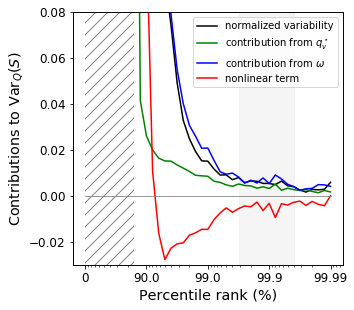

CPU times: user 1.07 s, sys: 99.5 ms, total: 1.17 s
Wall time: 1.17 s


In [53]:
%%time 
print("> plot variance and corresponding contributions")

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))

ax.set_ylim((-0.03,0.08))

# Grey shading 
i_Q_lims = (iQ_slice.start, iQ_slice.stop-1)
subplotXShadingRanksILog(ax,ranks_ref,i_Q_lims,alpha=0.15,transformX=False)

# zero line
addZeroLine(ax,ranks_ref)

# subplotRanksILog(ax,ranks,np.zeros(ranks.shape),ltype=':',col='k')
subplotRanksILog(ax,ranks_ref,
                 norm_var_pr_scOGS09_prQ,
                 col='k',ltype='-',transformX=False)

subplotRanksILog(ax,ranks_ref,
                 [contribQOmega_varOGS09_QPrime,contribQOmega_varOGS09_OmegaPrime,
                          contribQOmega_varOGS09_residual],
                 col=['green','blue','red'],ltype=['-','-','-'],transformX=False)

addXHatchRanksILog(ax,ranks_ref,(0,iQ_min),transformX=True)

ax.set_xlabel('Percentile rank (%)')
ax.set_ylabel(r'Contributions to Var$_Q(S)$')

ax.legend(['normalized variability',
           r'contribution from $q_v^\star$',
           r'contribution from $\omega$',
           r'nonlinear term'],ncol=1,framealpha=0.8,loc='upper right')

plt.savefig(os.path.join(figdir,'var_and_simple_contributions_scOGS09_%s.pdf'%output_suffix),
            bbox_inches='tight')

plt.show()

### Redo simpler decomposition for single-level scaling

In [51]:
print()
print("- Decompose qvstar_s and omega_500 into percentile-mean and departures from the mean")
print()

contribQOmega_varSL_scSL = np.nan*np.empty((len(ranks_ref)))
contribQOmega_varSL_QPrime = np.nan*np.empty((len(ranks_ref)))
contribQOmega_varSL_OmegaPrime = np.nan*np.empty((len(ranks_ref)))
contribQOmega_varSL_QPrimeOmegaPrime = np.nan*np.empty((len(ranks_ref)))

# for rank in targetranks:
for rank in targetranks:
    rankid = rankID(rank)
    #- Get profiles and fluctuations at given percentile
    stencil_Q = rank_locations[rankid]
    if stencil_Q.sum() == 0:
        continue
    omega_500_Q = sampleFlattened(omega_500,stencil_Q)
    nQ = len(omega_500_Q)
    qvstar_s_Q = sampleFlattened(qvstar_s,stencil_Q)
    m_omega_500_Q = np.nanmean(omega_500_Q)
    m_qvstar_s_Q = np.nanmean(qvstar_s_Q)
    m_omega_500_Q_ntimes = np.repeat(m_omega_500_Q,nQ)
    m_qvstar_s_Q_ntimes = np.repeat(m_qvstar_s_Q,nQ)
    prime_omega_500_Q = omega_500_Q-m_omega_500_Q_ntimes
    prime_qvstar_s_Q = qvstar_s_Q-m_qvstar_s_Q_ntimes

    sc_prQ = m_omega_500_Q*m_qvstar_s_Q
    sc_Q = omega_500_Q*qvstar_s_Q
    sc_Q_qvstarPrime = omega_500_Q*prime_qvstar_s_Q
    sc_Q_omegaPrime = prime_omega_500_Q*qvstar_s_Q
    sc_Q_omegaPrime_qvstarPrime = prime_omega_500_Q*prime_qvstar_s_Q

    #- Store results in array
    iQ = indexOfRank(rank,ranks_ref)
    contribQOmega_varSL_scSL[iQ] = np.nanvar(sc_Q)/sc_prQ**2
    contribQOmega_varSL_QPrime[iQ] = np.nanvar(sc_Q_qvstarPrime)/sc_prQ**2
    contribQOmega_varSL_OmegaPrime[iQ] = np.nanvar(sc_Q_omegaPrime)/sc_prQ**2
    contribQOmega_varSL_QPrimeOmegaPrime[iQ] = np.nanvar(sc_Q_omegaPrime_qvstarPrime)/sc_prQ**2

contribQOmega_varSL_residual = contribQOmega_varSL_scSL - contribQOmega_varSL_QPrime - contribQOmega_varSL_OmegaPrime
    # all_contribQOmega_varOGS09 = [contribQOmega_varOGS09_varQ,contribQOmega_varOGS09_varOmega,
    #                           contribQOmega_varOGS09_covQOmega]


- Decompose qvstar_s and omega_500 into percentile-mean and departures from the mean



> plot variance and corresponding contributions


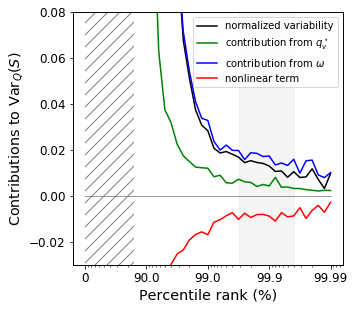

CPU times: user 945 ms, sys: 80.1 ms, total: 1.02 s
Wall time: 1.02 s


In [56]:
%%time 
print("> plot variance and corresponding contributions")

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))

ax.set_ylim((-0.03,0.08))

# Grey shading 
i_Q_lims = (iQ_slice.start, iQ_slice.stop-1)
subplotXShadingRanksILog(ax,ranks_ref,i_Q_lims,alpha=0.15,transformX=False)

# zero line
addZeroLine(ax,ranks_ref)

# subplotRanksILog(ax,ranks,np.zeros(ranks.shape),ltype=':',col='k')
subplotRanksILog(ax,ranks_ref,
                 norm_var_pr_sc_prQ,
                 col='k',ltype='-',transformX=False)

subplotRanksILog(ax,ranks_ref,
                 [contribQOmega_varSL_QPrime,contribQOmega_varSL_OmegaPrime,
                          contribQOmega_varSL_residual],
                 col=['green','blue','red'],ltype=['-','-','-'],transformX=False)

addXHatchRanksILog(ax,ranks_ref,(0,iQ_min),transformX=True)

ax.set_xlabel('Percentile rank (%)')
ax.set_ylabel(r'Contributions to Var$_Q(S)$')

ax.legend(['normalized variability',
           r'contribution from $q_v^\star$',
           r'contribution from $\omega$',
           r'nonlinear term'],ncol=1,framealpha=0.8,loc='upper right')

plt.savefig(os.path.join(figdir,'var_and_simple_contributions_sc_%s.pdf'%output_suffix),
            bbox_inches='tight')

plt.show()

# Save variables

In [133]:
print("- save variables with pickle.dump")

- save variables with pickle.dump


In [59]:
all_vars_to_save = ['contribQOmega_varSL_scSL','contribQOmega_varSL_QPrime',
                    'contribQOmega_varSL_OmegaPrime','contribQOmega_varSL_residual',
                    'contribQOmega_varOGS09_scOGS09','contribQOmega_varOGS09_QPrime',
                    'contribQOmega_varOGS09_OmegaPrime','contribQOmega_varOGS09_residual']
all_vars_to_save.sort()

In [60]:
print(len(all_vars_to_save),"variables")

size_pickle = 0
dict_pickle = {}
for v in all_vars_to_save:
    obj = getattr(thismodule,v)
    size_pickle += sys.getsizeof(obj)
    if obj.__class__ is np.ndarray:
        print('.',v,obj.__class__,sys.getsizeof(obj),obj.shape)
    else:
        print('.',v,obj.__class__,sys.getsizeof(obj))
    # save variables
    dict_pickle[v] = obj

8 variables
. contribQOmega_varOGS09_OmegaPrime <class 'numpy.ndarray'> 424 (41,)
. contribQOmega_varOGS09_QPrime <class 'numpy.ndarray'> 424 (41,)
. contribQOmega_varOGS09_residual <class 'numpy.ndarray'> 424 (41,)
. contribQOmega_varOGS09_scOGS09 <class 'numpy.ndarray'> 424 (41,)
. contribQOmega_varSL_OmegaPrime <class 'numpy.ndarray'> 424 (41,)
. contribQOmega_varSL_QPrime <class 'numpy.ndarray'> 424 (41,)
. contribQOmega_varSL_residual <class 'numpy.ndarray'> 424 (41,)
. contribQOmega_varSL_scSL <class 'numpy.ndarray'> 424 (41,)


In [61]:
result_dict_file = 'results_dictionary_variability_%s.pickle'%output_suffix
print("> save to file %s"%result_dict_file)
pickle.dump(dict_pickle,open(os.path.join(resultdir,result_dict_file),"wb"))
print("total size =",size_pickle,"B")

> save to file results_dictionary_variability_Q8-Q41_185005010100-185105010000.pickle
total size = 3392 B


In [62]:
print()
print("-------")
print()
if tracktime:
    timingfile = 'timing.csv'
    fulltimingfile = os.path.join(resultdir,timingfile)
    t_loops.append(time.time())
    time_elapsed_s = t_loops[-1]-t_loops[-2]
    print("time spent for scales %s and %s :"%(time_stride,resolution),
          time2str(time_elapsed_s))
    print()
    print('> Save timing and size info to %s.'%fulltimingfile)
    timing_df = saveTiming(fulltimingfile,output_suffix,pr.size,time_elapsed_s,reset_value=True)
print()


-------

time spent for scales 1d and 1dx : 01:09:18

> Save timing and size info to /global/u2/b/bfildier/code/dataAnalysis/extreme-rain-predictability-across-scales/results/omega500tsps/FSPCAMm_AMIP/piControl/r1i1p1/tropics/1d/1dx/timing.csv.



In [142]:
#--# stop indentation for multiple scales

## Keep track of time
if tracktime:
    print()
    print("-----------------------------------------------------------------")
    print("!                                                            \t!")
    print("!   time spent in each loop:                                 \t!")
    for i in range(len(t_loops)-1):
        print("!       ",time2str(t_loops[i+1]-t_loops[i]),
        "                                           \t!")
    print("!                                                            \t!")
    print("!   time spent in all loops combined:",
          time2str(t_loops[-1]-t_loops[0]),
          "             \t!")
    if len(t_loops) > 1:
        print("!   average time spent in a loop:",
              time2str((t_loops[-1]-t_loops[0])/(len(t_loops)-1)),
              "             \t!")
    print("!                                                            \t!")
    print("!   total time spent for script execution:",
          time2str(t_loops[-1]-t0),
          "         \t!")
    print("!                                                            \t!")
    print("-----------------------------------------------------------------")
    print()
        


-----------------------------------------------------------------
!                                                            	!
!   time spent in each loop:                                 	!
!        04:27:32                                            	!
!                                                            	!
!   time spent in all loops combined: 04:27:32              	!
!   average time spent in a loop: 04:27:32              	!
!                                                            	!
!   total time spent for script execution: 04:27:34          	!
!                                                            	!
-----------------------------------------------------------------

